# GBT DCR "Decoding"

We use the term "decoding" to refer to the process by which the relevant FITS files associated with a given DCR scan are processed and merged together. You might also hear the term "filling" used instead.

There are two FITS files that contribute to "the data":
1. `DCR`: contains "the data" and the DCR-related metadata
2. `IF`: contains receiver metadata

These must be properly parsed, ordered, and joined in order for sensible queries to be performed on the result.

This document is based on commit `ba57ddacb649fa85ee8e08acfc0e962babf2812f`

For this demo, we will be a _single_ scan from a given receiver. For example, if we select the Ku band receiver (Rcvr12_18), which has 2 beams, each with 1 polarization (circular), then we essentially have two physical incoming data streams:


| Port | Receptor | Polarization |  
| ---- | -------- | ------------ |  
| 2    | L1       | L            |  
| 4    | R1       | R            |  

However, since this data was taken over time as a series of integrations, it is not stored as a simple port->data mapping! It was taken with the DCR backend, which provides a calibration diode and a signal/reference beam switch. By combining these two binary states, we end up with 4 "phases" under which data was taken:

| `SIGREF` | `CAL` |      Phase key       | Phase index |
|----------|-------|----------------------|-------------|
|        0 |     0 | `Signal / No Cal`    |           0 |
|        0 |     1 | `Signal / Cal`       |           1 |
|        1 |     0 | `Reference / No Cal` |           2 |
|        1 |     1 | `Reference / Cal`    |           3 |

So, our resultant data is actually time-domain data (i.e. per-integration) of the shape `(integration, port, phase)`. Our task, then is to figure out how to map each physical datastream up with its data

## Step 1: Data Aquisition

In [53]:
import os

from astropy.io import fits

# Examples to choose from:
examples = {
    "L": ("./AGBT16B_285_01:1:Rcvr1_2", "2016_11_02_09:07:00.fits"),
    "X": ("./AGBT17A_056_10:1:Rcvr8_10", "2017_04_02_18:30:39.fits"),
    "Ku": ("./AGBT02A_025_01:1000:Rcvr12_18", "2004_03_04_00:56:43.fits"),
    "W": ("./AGBT17A_212_05:6:Rcvr68_92", "2017_08_06_04:29:10.fits"),
    "Q": ("./AGBT16A_473_01:1:Rcvr40_52", "2016_12_13_09:09:56.fits"),
}

receiver = "Ku"

# We have the contents of a single scan tracked within this repo
fits_dir = examples[receiver][0]
dcr_hdul = fits.open(os.path.join(fits_dir, 'DCR', examples[receiver][1]))
if_hdul = fits.open(os.path.join(fits_dir, 'IF', examples[receiver][1]))

## Step 2: Table Initialization

We will now convert our `HDUList` objects to `Table` objects so they can be more easily manipulated

### Step 2.1: DCR State Table Conversion

In [54]:
from astropy.table import Table

# Load the FITS STATE table into an astropy Table
dcr_state_table = Table.read(dcr_hdul[dcr_hdul.index_of('STATE')])
# Show it below
dcr_state_table

BLANKTIM,PHASETIM,SIGREF,CAL,SWSIG1,SWSIG2,SWSIG3,SWSIG4,SWSIG5
s,s,,,,,,,
float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8
0.0,0.1,0,0,0,0,0,0,1


Now let's trim off the columns we don't need, and then add some "helper" columns that more concisely describe the phase represented (since this is how we'll be thinking about the data) anyway

In [55]:
import numpy as np
from astropy.table import Column

# Trim off unneeded columns
# This creates a new "view" into the Table; no copy
dcr_state_table = dcr_state_table['SIGREF', 'CAL']

# Construct the "verbose" phases
phases_verbose = [
    '{} / {}'.format('Signal' if not sigref else 'Reference', 'Cal' if cal else 'No Cal')
    for sigref, cal in dcr_state_table
]
# Create the two new columns and add them to the state table
dcr_state_table.add_columns([
    # This column holds the phase index -- see above table
    Column(
        name='PHASE_INDEX',
        data=np.arange(len(phases_verbose))
    ),
    # This column holds the verbose name of each phase -- see above table
    Column(
        name='PHASE',
        data=phases_verbose
    )
])
dcr_state_table

SIGREF,CAL,PHASE_INDEX,PHASE
uint8,uint8,int64,str15
0,0,0,Signal / No Cal


### Step 2.2: DCR Data Table Initialization

In [56]:
# Load the FITS DATA table into an astropy Table
dcr_data_table = Table.read(dcr_hdul[dcr_hdul.index_of('DATA')])
dcr_data_table

IFFLAG,SUBSCAN,TIMETAG,"DATA [4,1]"
CODE,CODE,DMJD,COUNTS
int16,int32,float64,int32
0,1,57971.186932872566,150233 .. 137184
0,2,57971.1869340298,149713 .. 137125
0,3,57971.18693518717,149607 .. 137206
0,4,57971.1869363446,150284 .. 137272
0,5,57971.186937502025,149852 .. 137283
0,6,57971.18693865942,149472 .. 137176
0,7,57971.18693981683,149142 .. 137189
0,8,57971.18694097426,148620 .. 137176


### Step 2.3: IF IF Table Initialization

(The IF table of the IF `HDUList`)

Initialize the table:

In [57]:
# Load the FITS IF table into an astropy Table
if_if_table = Table.read(if_hdul[if_hdul.index_of('IF')])
if_if_table

BACKEND,BANK,PORT,RECEIVER,FEED,SRFEED1,SRFEED2,RECEPTOR,LO_CIRCUIT,LO_COMPONENT,SIDEBAND,POLARIZE,CENTER_IF,CENTER_SKY,BANDWDTH,HIGH_CAL,TEST_TONE_IF,TEST_TONE_SKY,TEST_TONE_CIRCUIT,TEST_TONE_COMPONENT,SFF_MULTIPLIER,SFF_SIDEBAND,SFF_OFFSET,TRANSFORM_COUNT,TRANSFORMS
none,none,none,none,none,none,none,none,none,none,none,none,Hz,Hz,Hz,none,Hz,Hz,none,none,none,none,none,none,none
str32,str2,int32,str32,int32,int32,int32,str8,str32,str32,str2,str2,float32,float32,float32,int32,float32,float32,str32,str32,float64,float64,float64,int32,str4096
DCR,A,1,Rcvr68_92,1,0,0,B1XL1,LO1A,synthesizer,L,X,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B1XL1): 68000 to 92000, linear_x polarization; filter(Rcvr68_92:FL1XL1): 66000 to 92000; mixer(Rcvr68_92:MX1XL1): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CXL1): 17000 x1; (Rcvr68_92:J1): ; (MMConverter1:J1): ; filter(MMConverter1:FL2): 7000 to 14000; mixer(MMConverter1:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter1:FL5): 4000 to 8000; (MMConverter1:J6): ; (IFRouter:J6): ; (IFRouter:J65): ; (OpticalDriver1:J1): ; attenuator(OpticalDriver1:attenuator): ; filter(OpticalDriver1:F8): 5360 to 6640; (OpticalDriver1:J4): ; (DCR:J1): ;"
DCR,A,3,Rcvr68_92,1,0,0,B1YR1,LO1A,synthesizer,L,Y,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B1YR1): 68000 to 92000, linear_y polarization; filter(Rcvr68_92:FL1YR1): 66000 to 92000; mixer(Rcvr68_92:MX1YR1): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CYR1): 17000 x1; (Rcvr68_92:J2): ; (MMConverter2:J1): ; filter(MMConverter2:FL2): 7000 to 14000; mixer(MMConverter2:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter2:FL5): 4000 to 8000; (MMConverter2:J6): ; (IFRouter:J22): ; (IFRouter:J67): ; (OpticalDriver3:J1): ; attenuator(OpticalDriver3:attenuator): ; filter(OpticalDriver3:F8): 5360 to 6640; (OpticalDriver3:J4): ; (DCR:J3): ;"
DCR,A,5,Rcvr68_92,2,0,0,B2X2,LO1A,synthesizer,L,X,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B2X2): 68000 to 92000, linear_x polarization; filter(Rcvr68_92:FL1X2): 66000 to 92000; mixer(Rcvr68_92:MX1X2): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CX2): 17000 x1; (Rcvr68_92:J3): ; (MMConverter3:J1): ; filter(MMConverter3:FL2): 7000 to 14000; mixer(MMConverter3:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter3:FL5): 4000 to 8000; (MMConverter3:J6): ; (IFRouter:J39): ; (IFRouter:J69): ; (OpticalDriver5:J1): ; attenuator(OpticalDriver5:attenuator): ; filter(OpticalDriver5:F8): 5360 to 6640; (OpticalDriver5:J4): ; (DCR:J5): ;"
DCR,A,7,Rcvr68_92,2,0,0,B2Y2,LO1A,synthesizer,L,Y,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B2Y2): 68000 to 92000, linear_y polarization; filter(Rcvr68_92:FL1Y2): 66000 to 92000; mixer(Rcvr68_92:MX1Y2): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CY2): 17000 x1; (Rcvr68_92:J4): ; (MMConverter4:J1): ; filter(MMConverter4:FL2): 7000 to 14000; mixer(MMConverter4:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter4:FL5): 4000 to 8000; (MMConverter4:J6): ; (IFRouter:J53): ; (IFRouter:J71): ; (OpticalDriver7:J1): ; attenuator(OpticalDriver7:attenuator): ; filter(OpticalDriver7:F8): 5360 to 6640; (OpticalDriver7:J4): ; (DCR:J7): ;"
VEGAS,A,1,Rcvr68_92,1,0,0,B1XL1,LO1A,synthesizer,L,X,896499000.0,77136500000.0,1007002000.0,0,nan,nan,,,4.0,-1.0,12032998000.0,29,"feed(Rcvr68_92:B1XL1): 68000 to 92000, linear_x polarization; filter(Rcvr68_92:FL1XL1): 66000 to 92000; mixer(Rcvr68_92:MX1XL1): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CXL1): 17000 x1; (Rcvr68_92:J1): ; (MMConverter1:J1): ; filter(MMConverter1:FL2): 7000 to 14000; mixer(MMConverter1:MX): LO: 17000 (x1) from LO

Throw out non-DCR rows:

In [58]:
# Note that we need to strip whitespace here -- our FITS files pad strings to
# the full width of their column
# After that we can simply create a mask of all rows where the BACKEND column contains "DCR"...
backend_mask = (np.char.rstrip(if_if_table['BACKEND']) == 'DCR')
# ...and use it to create a new view into the table
if_if_table = if_if_table[backend_mask]
if_if_table

BACKEND,BANK,PORT,RECEIVER,FEED,SRFEED1,SRFEED2,RECEPTOR,LO_CIRCUIT,LO_COMPONENT,SIDEBAND,POLARIZE,CENTER_IF,CENTER_SKY,BANDWDTH,HIGH_CAL,TEST_TONE_IF,TEST_TONE_SKY,TEST_TONE_CIRCUIT,TEST_TONE_COMPONENT,SFF_MULTIPLIER,SFF_SIDEBAND,SFF_OFFSET,TRANSFORM_COUNT,TRANSFORMS
none,none,none,none,none,none,none,none,none,none,none,none,Hz,Hz,Hz,none,Hz,Hz,none,none,none,none,none,none,none
str32,str2,int32,str32,int32,int32,int32,str8,str32,str32,str2,str2,float32,float32,float32,int32,float32,float32,str32,str32,float64,float64,float64,int32,str4096
DCR,A,1,Rcvr68_92,1,0,0,B1XL1,LO1A,synthesizer,L,X,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B1XL1): 68000 to 92000, linear_x polarization; filter(Rcvr68_92:FL1XL1): 66000 to 92000; mixer(Rcvr68_92:MX1XL1): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CXL1): 17000 x1; (Rcvr68_92:J1): ; (MMConverter1:J1): ; filter(MMConverter1:FL2): 7000 to 14000; mixer(MMConverter1:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter1:FL5): 4000 to 8000; (MMConverter1:J6): ; (IFRouter:J6): ; (IFRouter:J65): ; (OpticalDriver1:J1): ; attenuator(OpticalDriver1:attenuator): ; filter(OpticalDriver1:F8): 5360 to 6640; (OpticalDriver1:J4): ; (DCR:J1): ;"
DCR,A,3,Rcvr68_92,1,0,0,B1YR1,LO1A,synthesizer,L,Y,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B1YR1): 68000 to 92000, linear_y polarization; filter(Rcvr68_92:FL1YR1): 66000 to 92000; mixer(Rcvr68_92:MX1YR1): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CYR1): 17000 x1; (Rcvr68_92:J2): ; (MMConverter2:J1): ; filter(MMConverter2:FL2): 7000 to 14000; mixer(MMConverter2:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter2:FL5): 4000 to 8000; (MMConverter2:J6): ; (IFRouter:J22): ; (IFRouter:J67): ; (OpticalDriver3:J1): ; attenuator(OpticalDriver3:attenuator): ; filter(OpticalDriver3:F8): 5360 to 6640; (OpticalDriver3:J4): ; (DCR:J3): ;"
DCR,A,5,Rcvr68_92,2,0,0,B2X2,LO1A,synthesizer,L,X,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B2X2): 68000 to 92000, linear_x polarization; filter(Rcvr68_92:FL1X2): 66000 to 92000; mixer(Rcvr68_92:MX1X2): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CX2): 17000 x1; (Rcvr68_92:J3): ; (MMConverter3:J1): ; filter(MMConverter3:FL2): 7000 to 14000; mixer(MMConverter3:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter3:FL5): 4000 to 8000; (MMConverter3:J6): ; (IFRouter:J39): ; (IFRouter:J69): ; (OpticalDriver5:J1): ; attenuator(OpticalDriver5:attenuator): ; filter(OpticalDriver5:F8): 5360 to 6640; (OpticalDriver5:J4): ; (DCR:J5): ;"
DCR,A,7,Rcvr68_92,2,0,0,B2Y2,LO1A,synthesizer,L,Y,6000000000.0,77000000000.0,1280000000.0,0,nan,nan,,,4.0,-1.0,17000000000.0,17,"feed(Rcvr68_92:B2Y2): 68000 to 92000, linear_y polarization; filter(Rcvr68_92:FL1Y2): 66000 to 92000; mixer(Rcvr68_92:MX1Y2): LO: 66000 (x4) from LO1A:synthesizer, IFo = IFi - 66000; tone(Rcvr68_92:CY2): 17000 x1; (Rcvr68_92:J4): ; (MMConverter4:J1): ; filter(MMConverter4:FL2): 7000 to 14000; mixer(MMConverter4:MX): LO: 17000 (x1) from LO1B:synthesizer, IFo = 17000 - IFi; filter(MMConverter4:FL5): 4000 to 8000; (MMConverter4:J6): ; (IFRouter:J53): ; (IFRouter:J71): ; (OpticalDriver7:J1): ; attenuator(OpticalDriver7:attenuator): ; filter(OpticalDriver7:F8): 5360 to 6640; (OpticalDriver7:J4): ; (DCR:J7): ;"


Great, so we now have only two rows, one each for our two receptors. Now we trim off the columns that we don't need:

In [59]:
if_if_table = if_if_table['FEED', 'RECEPTOR', 'POLARIZE', 'CENTER_SKY', 'BANDWDTH', 'PORT', 'HIGH_CAL']
if_if_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT,HIGH_CAL
none,none,none,Hz,Hz,none,none
int32,str8,str2,float32,float32,int32,int32
1,B1XL1,X,77000000000.0,1280000000.0,1,0
1,B1YR1,Y,77000000000.0,1280000000.0,3,0
2,B2X2,X,77000000000.0,1280000000.0,5,0
2,B2Y2,Y,77000000000.0,1280000000.0,7,0


We have two more `str` columns; let's strip the whitespace from them, too (in a proper program this would be handled more sensibly, of course)

In [60]:
if_if_table['RECEPTOR'] = np.char.rstrip(if_if_table['RECEPTOR'])
if_if_table['POLARIZE'] = np.char.rstrip(if_if_table['POLARIZE'])

Now we add a `PORT_INDEX` column to make indexing easier later on:

In [61]:
if_if_table.add_column(
    Column(
        name='PORT_INDEX',
        data=np.arange(len(np.unique(if_if_table['PORT']))),
        
    ),
    index=if_if_table.columns.keys().index("PORT")
)

if_if_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT_INDEX,PORT,HIGH_CAL
none,,,Hz,Hz,,none,none
int32,str8,str2,float32,float32,int64,int32,int32
1,B1XL1,X,77000000000.0,1280000000.0,0,1,0
1,B1YR1,Y,77000000000.0,1280000000.0,1,3,0
2,B2X2,X,77000000000.0,1280000000.0,2,5,0
2,B2Y2,Y,77000000000.0,1280000000.0,3,7,0


## Step 3: Joining the Tables

Okay, so we now have all of our tables set up! But for what purpose?

We now need to map each physical attribute (beam/port/etc.) to every permutation of phase. This means that, in this simple case, we will end up with `numPols` * `numPhases` (more complicated cases will require more terms). So, we determine that we need to have 8 total rows:

In [62]:
print("{} polarizations...".format(len(if_if_table)))
print("...across {} phases...".format(len(dcr_state_table)))
print("...yields {} total states under which data was taken".format(len(if_if_table) * len(dcr_state_table)))

4 polarizations...
...across 1 phases...
...yields 4 total states under which data was taken


We can represent these permutations by "inflating" our tables using `vstack` so that they are each 8 rows.

First the `IF` table:

In [63]:
from astropy.table import vstack

# Stack the IF table on top of itself 4 times to yield 8 total rows
stacked_if_table = vstack([if_if_table] * len(dcr_state_table))
# We must sort here so that we can properly join with the state table later -- we need one port on top of the other,
# not mixed together!
stacked_if_table.sort('PORT')
stacked_if_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT_INDEX,PORT,HIGH_CAL
none,,,Hz,Hz,,none,none
int32,str8,str2,float32,float32,int64,int32,int32
1,B1XL1,X,77000000000.0,1280000000.0,0,1,0
1,B1YR1,Y,77000000000.0,1280000000.0,1,3,0
2,B2X2,X,77000000000.0,1280000000.0,2,5,0
2,B2Y2,Y,77000000000.0,1280000000.0,3,7,0


And now the `STATE` table:

In [64]:
# Stack STATE table on top of itself 2 times to reach 8 total rows
stacked_state_table = vstack([dcr_state_table] * len(if_if_table))
stacked_state_table

SIGREF,CAL,PHASE_INDEX,PHASE
uint8,uint8,int64,str15
0,0,0,Signal / No Cal
0,0,0,Signal / No Cal
0,0,0,Signal / No Cal
0,0,0,Signal / No Cal


Great, now we have two tables of compatible shapes! We just need to stick them together:

In [65]:
# Ignore the warnings here; don't care in this simple example
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', AstropyWarning)

from astropy.table import hstack

# Join the tables together horizontally
dcr_table = hstack([stacked_if_table, stacked_state_table])
dcr_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT_INDEX,PORT,HIGH_CAL,SIGREF,CAL,PHASE_INDEX,PHASE
none,,,Hz,Hz,,none,none,,,,
int32,str8,str2,float32,float32,int64,int32,int32,uint8,uint8,int64,str15
1,B1XL1,X,77000000000.0,1280000000.0,0,1,0,0,0,0,Signal / No Cal
1,B1YR1,Y,77000000000.0,1280000000.0,1,3,0,0,0,0,Signal / No Cal
2,B2X2,X,77000000000.0,1280000000.0,2,5,0,0,0,0,Signal / No Cal
2,B2Y2,Y,77000000000.0,1280000000.0,3,7,0,0,0,0,Signal / No Cal


## Data Selection

Now, let's take a quick detour to discuss how the data selection is going to work. `DCR.DATA.DATA` is time-domain data (i.e. per-integration) of the shape `(integration, port, phase)`:

In [66]:
print("Shape: {}".format(dcr_data_table['DATA'].shape))
print("i.e. {} integrations, each with data from {} ports, each with data taken across {} phases".format(*dcr_data_table['DATA'].shape))

Shape: (3649, 4, 1)
i.e. 3649 integrations, each with data from 4 ports, each with data taken across 1 phases


We need to slice this out into the physical domain (i.e. per-data-stream) -- that is, get all of the data from all integrations that was taken for each unique set of physical attributes (port and phase). Let's take the first port (2) and the first phase (0, 0) as an example:

In [67]:
data = dcr_data_table['DATA']
# All data taken in the first integration
data[0]

array([[150233],
       [134391],
       [155981],
       [137184]], dtype=int32)

In [68]:
# All data taken via the first port in the first integration
data[0][0]

array([150233], dtype=int32)

In [69]:
# Phase "Signal / No Cal" datum taken via the first port in the first integration
data[0][0][0]

150233

#### NumPy Data Selection

But, how do we select data from this port/phase over _all_ integrations?

In [70]:
# All data taken via the first port
data[:, 0]

150233
149713
149607
150284
149852
149472
149142
148620
148509
148422
148341


In [71]:
# All data with phase phase "Signal / No Cal" taken via the first port
data[:, 0, 0]

150233
149713
149607
150284
149852
149472
149142
148620
148509
148422
148341


## Step 4: Map the Data

Add an empty DATA column as a placeholder:

In [72]:
dcr_table.add_column(
    Column(
        name='DATA',
        dtype=dcr_data_table['DATA'].dtype,
        shape=dcr_data_table['DATA'].shape[0],
        length=len(dcr_table)
    )
)
dcr_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT_INDEX,PORT,HIGH_CAL,SIGREF,CAL,PHASE_INDEX,PHASE,DATA [3649]
none,,,Hz,Hz,,none,none,,,,,
int32,str8,str2,float32,float32,int64,int32,int32,uint8,uint8,int64,str15,int32
1,B1XL1,X,77000000000.0,1280000000.0,0,1,0,0,0,0,Signal / No Cal,0 .. 0
1,B1YR1,Y,77000000000.0,1280000000.0,1,3,0,0,0,0,Signal / No Cal,0 .. 0
2,B2X2,X,77000000000.0,1280000000.0,2,5,0,0,0,0,Signal / No Cal,0 .. 0
2,B2Y2,Y,77000000000.0,1280000000.0,3,7,0,0,0,0,Signal / No Cal,0 .. 0


Now, perform the actual selection of the data:

In [73]:
# For every row in our table...
for ri, row in enumerate(dcr_table):
    # ...Slice out the data from the DCR DATA table associated with the current phase and port,
    # and put it in the the DATA column of our new table
    dcr_table['DATA'][ri] = dcr_data_table['DATA'][::, row['PORT_INDEX'], row['PHASE_INDEX']]
    
dcr_table

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT_INDEX,PORT,HIGH_CAL,SIGREF,CAL,PHASE_INDEX,PHASE,DATA [3649]
none,,,Hz,Hz,,none,none,,,,,
int32,str8,str2,float32,float32,int64,int32,int32,uint8,uint8,int64,str15,int32
1,B1XL1,X,77000000000.0,1280000000.0,0,1,0,0,0,0,Signal / No Cal,150233 .. 149147
1,B1YR1,Y,77000000000.0,1280000000.0,1,3,0,0,0,0,Signal / No Cal,134391 .. 133583
2,B2X2,X,77000000000.0,1280000000.0,2,5,0,0,0,0,Signal / No Cal,155981 .. 155779
2,B2Y2,Y,77000000000.0,1280000000.0,3,7,0,0,0,0,Signal / No Cal,137184 .. 137654


Okay... but what can we *do* with this?

Let's try out something similar to what you might do in GFM: plot the "Signal / No Cal" phase for both polarizations

<IPython.core.display.Javascript object>


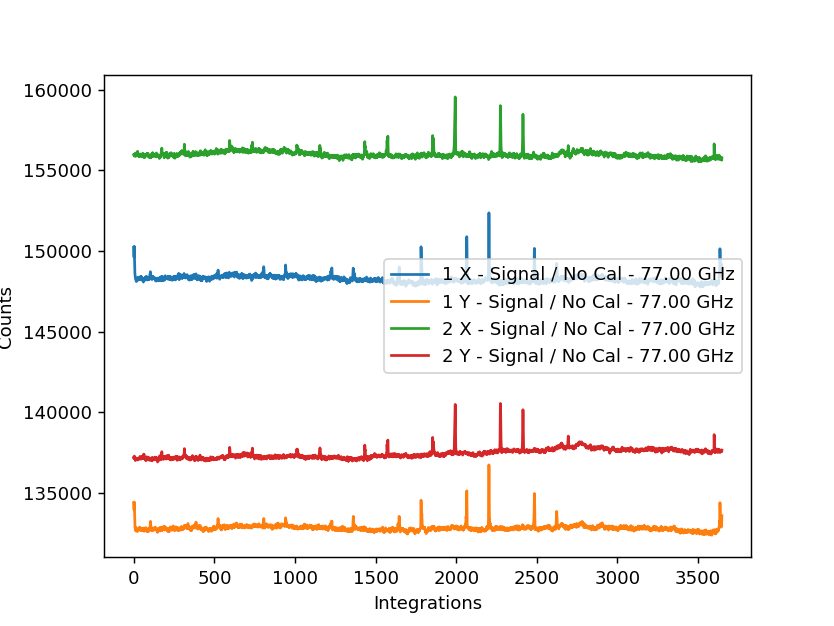

FEED,RECEPTOR,POLARIZE,CENTER_SKY,BANDWDTH,PORT_INDEX,PORT,HIGH_CAL,SIGREF,CAL,PHASE_INDEX,PHASE,DATA [3649]
none,,,Hz,Hz,,none,none,,,,,
int32,str8,str2,float32,float32,int64,int32,int32,uint8,uint8,int64,str15,int32
1,B1XL1,X,77000000000.0,1280000000.0,0,1,0,0,0,0,Signal / No Cal,150233 .. 149147
1,B1YR1,Y,77000000000.0,1280000000.0,1,3,0,0,0,0,Signal / No Cal,134391 .. 133583
2,B2X2,X,77000000000.0,1280000000.0,2,5,0,0,0,0,Signal / No Cal,155981 .. 155779
2,B2Y2,Y,77000000000.0,1280000000.0,3,7,0,0,0,0,Signal / No Cal,137184 .. 137654


In [75]:
%matplotlib notebook

from astropy import units
import matplotlib.pyplot as plt

# Mask out everything but 'Signal / No Cal' data
row_mask = dcr_table['PHASE'] == 'Signal / No Cal'
sig_no_cal = dcr_table[row_mask]
data = sig_no_cal['DATA']

# Transpose data here so that each row results in a new axis (instead of each column, which makes little sense)
plt.plot(data.T)
plt.xlabel('Integrations')
plt.ylabel('Counts')  
legend_format = '{FEED} {POLARIZE} - {PHASE} - {CENTER_SKY:.2f} GHz'
legend_data = [
    legend_format.format(
        FEED=row["FEED"],
        POLARIZE=row["POLARIZE"],
        PHASE=row["PHASE"],
        CENTER_SKY=units.Hz.to(units.GHz, row["CENTER_SKY"])
    ) for row in sig_no_cal
]
plt.legend(
    legend_data,
    #bbox_to_anchor=(1.15, 1.0)
)
# Display the plot
plt.show()
# Display the table being plotted
sig_no_cal